In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pyomo.environ as pyo

from matplotlib import rc

In [2]:
# Load global constants
from helper_functions import *
from constants import *
from linear_plant_dynamics import *
globals().update(locals())

In [3]:
# Simulation Settings
total_simulation_days = get_number_day(end_date) - get_number_day(start_date) # total simulation time in days,         [days]
total_time_steps      = total_simulation_days * num_time_steps_per_day        # total number of simulation time steps, [unitless]

In [4]:
# All distrubances
disturbances = np.loadtxt('exact_disturbances.csv', delimiter=',')

In [5]:
# Set initial conditions

# Initial state
initial_height         = 0.01 
initial_leaf_area      = 1e-5 
initial_canopy_biomass = 0.01 
initial_fruit_biomass  = 0.01 
initial_dAdt           = 1e-6 
initial_dcdt           = 1e-3

x0 = np.array([initial_height, initial_leaf_area, initial_canopy_biomass, initial_fruit_biomass, initial_dAdt, initial_dcdt])

In [6]:
# Initial input
initial_Weff = 0.00001
initial_WC   = 0.01
initial_WSL  = 1.2
initial_Feff = 0.01
initial_FC   = 0.01

u0 = np.array([initial_Weff, initial_WC, initial_WSL, initial_Feff, initial_FC])

In [7]:
# Set bounds on state values
height_min         = 0.01 
leaf_area_min      = 1e-5 
canopy_biomass_min = 0.01 
fruit_biomass_min  = 0.01 
dAdt_min           = 1e-7 
dcdt_min           = 1e-4

x_min = np.array([height_min, leaf_area_min, canopy_biomass_min, fruit_biomass_min, dAdt_min, dcdt_min])

height_max         = 2
leaf_area_max      = 0.01 
canopy_biomass_max = 2 
fruit_biomass_max  = 10 
dAdt_max           = 9e-6 
dcdt_max           = 9e-3 

x_max = np.array([height_max, leaf_area_max, canopy_biomass_max, fruit_biomass_max, dAdt_max, dcdt_max])

In [8]:
# Set bounds on input values
eff_irr_min       = 0.00001 
cum_irr_min       = 0.01 
leaf_sens_irr_min = 0.01 
eff_fert_min      = 0.01 
cum_fert_min      = 0.01 

u_min = np.array([eff_irr_min, cum_irr_min, leaf_sens_irr_min, eff_fert_min, cum_fert_min])

eff_irr_max       = 1e0
cum_irr_max       = eff_irr_max * total_time_steps 
leaf_sens_irr_max = 2
eff_fert_max      = 1e0
cum_fert_max      = eff_fert_max * total_time_steps 

u_max = np.array([eff_irr_max, cum_irr_max, leaf_sens_irr_max, eff_fert_max, cum_fert_max])

In [9]:
# CFTOC
def solve_cftoc(A, B, E, d, R, c, N, x0, x_min, x_max, u_min, u_max):

  nx = A.shape[1] # number of states
  nu = B.shape[1] # number of inputs
  nd = d.shape[0] # number of distrubances

  model = pyo.ConcreteModel()
  model.kidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
  model.xidx = pyo.Set(initialize=range(0, nx))
  model.uidx = pyo.Set(initialize=range(0, nu))
  model.didx = pyo.Set(initialize=range(0, nd))

  # Create state and input variable trajectories
  model.x = pyo.Var(model.xidx, model.kidx) # nx x N
  model.u = pyo.Var(model.uidx, model.kidx) # nu x N

  # Check stability of A
  #D, _ = np.linalg.eig(A)
  #print(D)

  # Objective
  def cost_function(model):
    cost = 0
    # Stage cost (u'Ru)
    for k in range(N):  # up to N-1
        cost += sum(R[i, j] * model.u[i, k] * model.u[j, k] for i in model.uidx for j in model.uidx)
    # Terminal cost (c'x)
    cost -= sum(c[i] * model.x[i, N] for i in model.xidx)
    return cost

  model.cost = pyo.Objective(rule=cost_function, sense=pyo.minimize)

  # Dynamics
  def dynamics(model, i, k):
    if k < N:
        return model.x[i, k+1] == sum(A[i, j] * model.x[j, k] for j in model.xidx) + \
                                  sum(B[i, j] * model.u[j, k] for j in model.uidx) + sum(E[i, j] * d[j, k] for j in model.didx)                                  
    else:
        return pyo.Constraint.Skip

  model.dynamics = pyo.Constraint(model.xidx, model.kidx, rule=dynamics)

  # Initial Condition
  model.initial_condition = pyo.Constraint(model.xidx, rule=lambda model, i: model.x[i, 0] == x0[i])

  # State Bounds
  model.state_min = pyo.Constraint(model.xidx, model.kidx, rule=lambda model, i, k: x_min[i] <= model.x[i, k])
  #model.state_max = pyo.Constraint(model.xidx, model.kidx, rule=lambda model, i, k: model.x[i, k] <= x_max[i])

  # Input Bounds
  model.input_min = pyo.Constraint(model.uidx, model.kidx, rule=lambda model, i, k: model.u[i, k] >= u_min[i])
  model.input_max = pyo.Constraint(model.uidx, model.kidx, rule=lambda model, i, k: model.u[i, k] <= u_max[i])

  # Solve
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model, tee=False)
  feas = results.solver.termination_condition == pyo.TerminationCondition.optimal

  # Retrieve the results
  if feas:
      xOpt = np.array([[model.x[i, k].value for k in model.kidx] for i in model.xidx])
      uOpt = np.array([[model.u[i, k].value for k in model.kidx] for i in model.uidx])
      JOpt = pyo.value(model.cost)
  else:
      raise ValueError("Optimization failed to find an optimal solution.")

  return [feas, xOpt, uOpt, JOpt]

In [10]:
# Solve CFTOC
d0 = disturbances[:, 0]
A = time_step_size * get_A(x0, u0, d0) + np.eye(6)
B = time_step_size * get_B(x0, u0, d0)
E = time_step_size * get_E(x0, u0, d0) 
R = np.eye(u0.shape[0])
c = 100 * np.ones_like(x0)
N = 24
d = disturbances[:, 0:N+1]
d = np.zeros_like(d)

In [11]:
[feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, E, d, R, c, N, x0, x_min, x_max, u_min, u_max)

In [12]:
# Plot state over horizon
#plot_state_over_horizon(xOpt, N)

In [13]:
# Plot inputs over horizon
#plot_input_over_horizon(uOpt, N)

In [14]:
# Plot disturbances over horizon
#plot_disturbances_over_horizon(d, N)

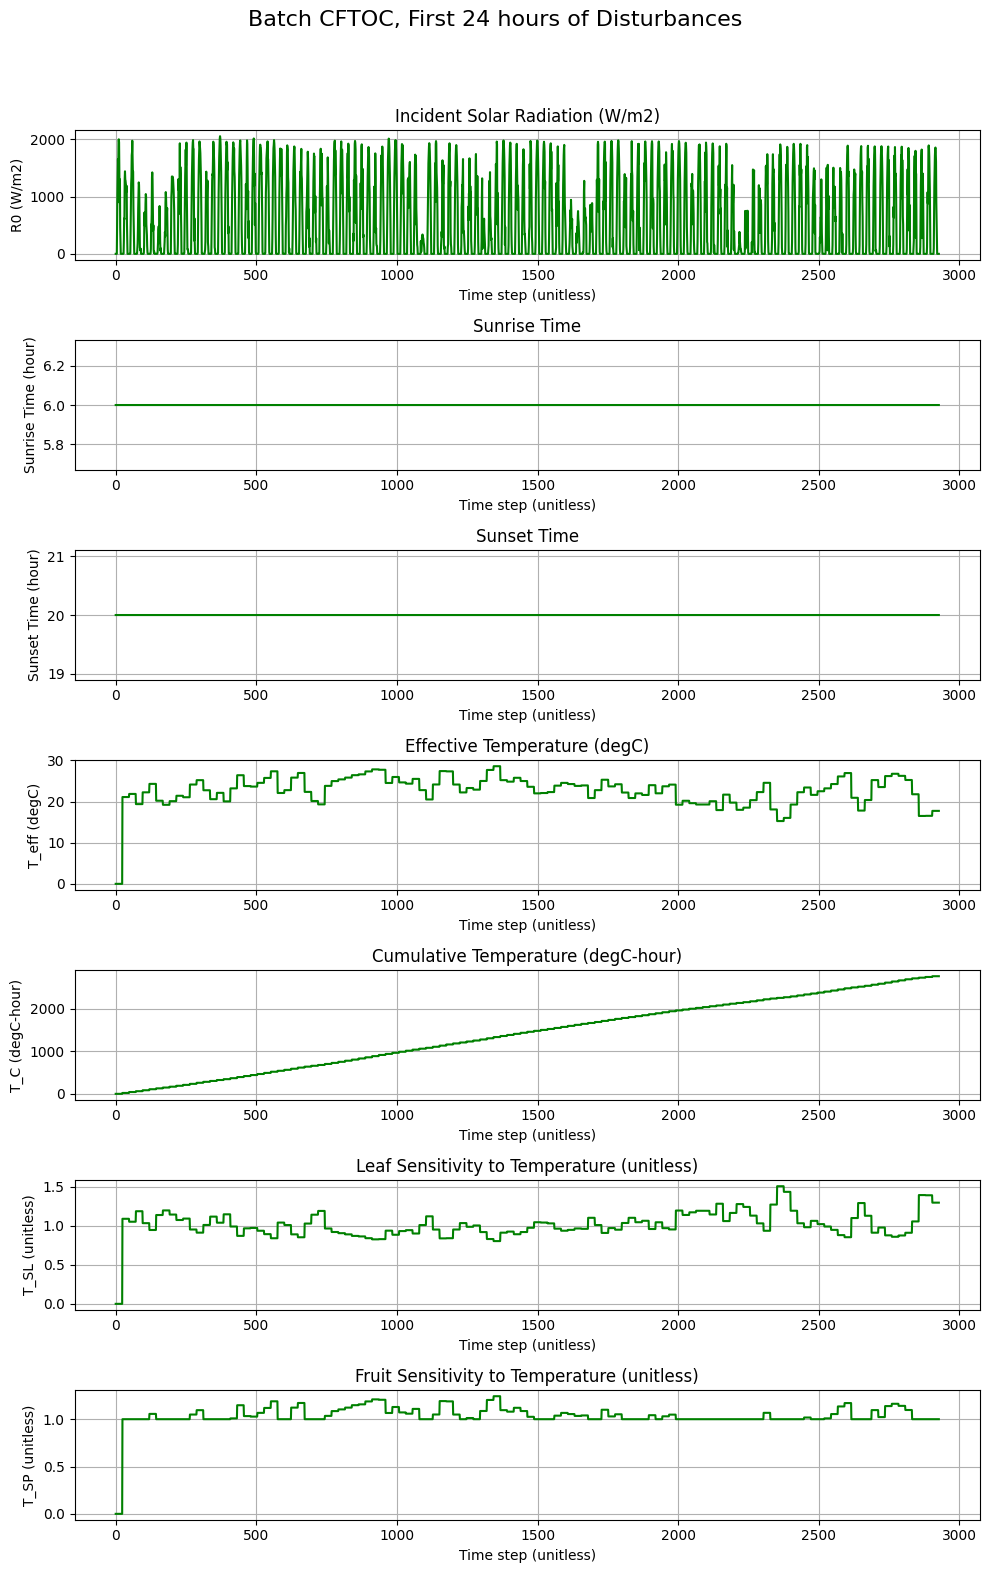

In [15]:
# Plot disturbances over growing season
plot_disturbances_over_horizon(disturbances, total_time_steps - 1)

u0:  [1.0e-05 1.0e-02 1.2e+00 1.0e-02 1.0e-02]
B*m [1.00096087e-04 2.50048043e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
B*m [0. 0. 0. 0. 0. 0.]
B*m [0. 0. 0. 0. 0. 0.]


/var/folders/fl/91zckx656v5f4h8x1sh87tfr0000gn/T/ipykernel_52915/2658079746.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")  # Other options include "viridis", "plasma", etc.


B*m [0. 0. 0. 0. 0. 0.]
B*m [0. 0. 0. 0. 0. 0.]
A_end: [[ 1.00296864e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.75000000e-10  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.49062764e-07  1.00000015e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.45250000e-09 -4.18291447e-11  0.00000000e+00
   4.75000000e-10  1.00000000e+00]]
B_end: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
E_end: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.00000000e-06
   0.00000000e+00  0.00000000e+0

Text(0, 0.5, 'Cumulative Fertilizer (kg*hour)')

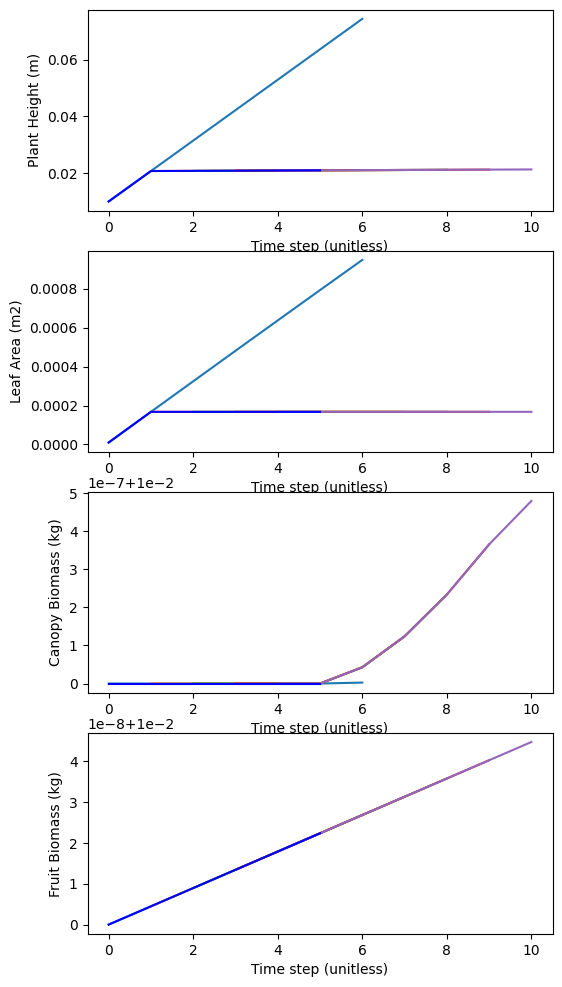

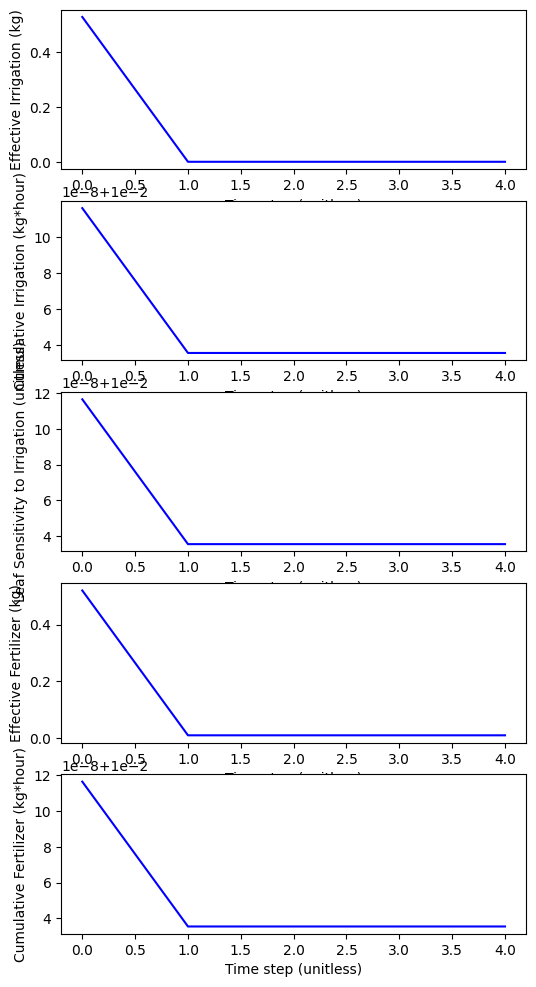

In [16]:
# MPC
from matplotlib.cm import get_cmap
nx = 6
nu = 5
nd = 7
#M = 2928
M = 5
N = 6

xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx,)
uOpt[:, 0] = u0.reshape(nu,)
print('u0: ', u0)

xPred = np.zeros((nx, N+1, M))
#predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M,), dtype=bool)
xN = np.zeros((nx,1))

fig, axs = plt.subplots(4, 1, figsize=(6, 12))
fig2, axs2 = plt.subplots(5, 1, figsize=(6, 12))

cmap = get_cmap("tab10")  # Other options include "viridis", "plasma", etc.
colors = [cmap(i) for i in range(M)]

for m in range(M):

    # Get latest state, input, and distrubance
    xm = xOpt[:, m]
    um = uOpt[:, m]
    dm = disturbances[:, m:m+N+1]

    # Get latest linearized dynamics
    A = time_step_size * get_A(xm, um, dm[:, 0]) + np.eye(6)
    B = time_step_size * get_B(xm, um, dm[:, 0])
    E = time_step_size * get_E(xm, um, dm[:, 0]) 

    print('B*m', B@um)
    
    A0 = np.zeros_like(A)
    B0 = np.zeros_like(B)
    E0 = np.zeros_like(E)


    # Run CFTOC for horizon
    [feas[m], x, u, J] = solve_cftoc(A, B, E, dm, R, c, N, xm, x_min, x_max, u_min, u_max)

    if not feas[m]:
        xOpt = []
        uOpt = []
        #predErr = []
        break

    # Save open loop predictions
    #xPred[:, :, m] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, m+1] = x[:, 1]
    uOpt[:, m]   = u[:, 0].reshape(nu,)

    # Plot Open Loop
    #open_loop = plt.plot(x[0,:], x[1,:], 'r--')
   
    axs[0].plot(np.arange(m, m+N+1), x[0], color=colors[m]) # Height
    axs[1].plot(np.arange(m, m+N+1), x[1], color=colors[m]) # Leaf Area
    axs[2].plot(np.arange(m, m+N+1), x[2], color=colors[m]) # Canopy Biomass
    axs[3].plot(np.arange(m, m+N+1), x[3], color=colors[m]) # Fruit Biomass

print('A_end:',A)
print('B_end:',B)
print('E_end:',E)
# Plot Closed Loop
#closed_loop = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
axs[0].plot(np.arange(M+1), xOpt[0, :], 'b-') # Height
axs[1].plot(np.arange(M+1), xOpt[1, :], 'b-') # Leaf Area
axs[2].plot(np.arange(M+1), xOpt[2, :], 'b-') # Canopy Biomass
axs[3].plot(np.arange(M+1), xOpt[3, :], 'b-') # Fruit Biomass

axs[0].set_xlabel('Time step (unitless)')
axs[0].set_ylabel('Plant Height (m)')
#axs[0].legend(['Open-loop', 'Closed-loop'])

axs[1].set_xlabel('Time step (unitless)')
axs[1].set_ylabel('Leaf Area (m2)')
#axs[1].legend(['Open-loop', 'Closed-loop'])

axs[2].set_xlabel('Time step (unitless)')
axs[2].set_ylabel('Canopy Biomass (kg)')
#axs[2].legend(['Open-loop', 'Closed-loop'])

axs[3].set_xlabel('Time step (unitless)')
axs[3].set_ylabel('Fruit Biomass (kg)')
#axs[3].legend(['Open-loop', 'Closed-loop'])

## plot inputs
#eff_irr_max, cum_irr_max, leaf_sens_irr_max, eff_fert_max, cum_fert_max

axs2[0].plot(np.arange(M), uOpt[0, :], 'b-') # effective irrigation
axs2[1].plot(np.arange(M), uOpt[1, :], 'b-') # cumulative irrigation
axs2[2].plot(np.arange(M), uOpt[2, :], 'b-') # leaf sensitivity irrigation
axs2[3].plot(np.arange(M), uOpt[3, :], 'b-') # effective fertilizer
axs2[4].plot(np.arange(M), uOpt[4, :], 'b-') # cumulative fertilizer


axs2[0].set_xlabel('Time step (unitless)')
axs2[0].set_ylabel('Effective Irrigation (kg)')
#axs[0].legend(['Open-loop', 'Closed-loop'])

axs2[1].set_xlabel('Time step (unitless)')
axs2[1].set_ylabel('Cumulative Irrigation (kg*hour)')
#axs[1].legend(['Open-loop', 'Closed-loop'])

axs2[2].set_xlabel('Time step (unitless)')
axs2[2].set_ylabel('Leaf Sensitivity to Irrigation (unitless)')
#axs[2].legend(['Open-loop', 'Closed-loop'])

axs2[3].set_xlabel('Time step (unitless)')
axs2[3].set_ylabel('Effective Fertilizer (kg)')
#axs[3].legend(['Open-loop', 'Closed-loop'])

axs2[4].set_xlabel('Time step (unitless)')
axs2[4].set_ylabel('Cumulative Fertilizer (kg*hour)')
#axs[3].legend(['Open-loop', 'Closed-loop'])

